# Прогноз оттока пользователей в фитнес-центрах

# Описание проекта

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что клиент больше не с вами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо.

Ваша задача — провести анализ и подготовить план действий по удержанию клиентов:
 
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента; - сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства; 
- проанализировать основные признаки, наиболее сильно влияющие на отток; 
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:

1. Выделить целевые группы клиентов 
2. Предложить меры по снижению оттока 
3. Определить другие особенности взаимодействия с клиентами.

«Культурист-датасаентист» предоставил следующие сведения:  

1. Данные клиента за предыдущий до проверки факта оттока месяц:  

`gender` — пол;  
`Near_Location` — проживание или работа в районе, где находится фитнес-центр;  
`Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);  
`Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);  
`Phone` — наличие контактного телефона;  
`Age` — возраст;  
`Lifetim` — время с момента первого обращения в фитнес-центр (в месяцах).  


2. Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:  

`Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);  
`Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);  
`Group_visits` — факт посещения групповых занятий;  
`Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;  
`Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;  
`Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон;  
`Churn` — факт оттока в текущем месяце.

## Обзор данных

In [1]:
#импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
#import re

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

#доп настройки
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
df = pd.read_csv('/datasets/gym_churn.csv')
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [4]:
df.duplicated().sum()

0

**Вывод:**  
В датасете представлена информация о 4000 клиентов.  
Каждая строка содержит информацию с полом, фактом проживания или работы в районе фитнес-центра, выделением сотрудников компании-партнёра клуба, фактом первоначальной записи в рамках акции «приведи друга», обозначением наличия контактного телефона, возрастом, временем с момента первого обращения в фитнес-центр, длительностью текущего действующего абонемента, сроком до окончания текущего действующего абонемента, фактом посещения групповых занятий, средней частотой посещений в неделю за все время с начала действия абонемента и за предыдущий месяц, суммарной выручкой от других услуг фитнес-центра, фактом оттока в текущем месяце.  

Всего 14 столбцов.  
Названия некоторых столбцов написаны в верхнем регистре.  

Пропусков нет.  
Дубликатов нет.

## Предобработка

### Приведение названий столбцов к стандартному виду

In [5]:
df = df.rename(columns=
               {'Near_Location' : 'near_location',
                'Partner' : 'partner',
                'Promo_friends' : 'promo_friends',
                'Phone' : 'phone',
                'Contract_period' : 'contract_period',
                'Group_visits' : 'group_visits',
                'Age' : 'age',
                'Avg_additional_charges_total' : 'avg_additional_charges_total',
                'Month_to_end_contract' : 'month_to_end_contract',
                'Lifetime' : 'lifetime',
                'Avg_class_frequency_total' : 'avg_class_frequency_total',
                'Avg_class_frequency_current_month' : 'avg_class_frequency_current_month',
                'Churn' : 'churn'
               })

### Значения в столбце с месяцами

Посмотрим на уникальные значения в столбце с месяцами

In [6]:
df['month_to_end_contract'].sort_values().unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])

In [7]:
#переведем тип данных в целочисленный
df.month_to_end_contract = df.month_to_end_contract.astype(np.int64)

## Исследовательский анализ данных (EDA)

### Средние значения и стандартные отклонения 

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,"4,000.00",0.51,0.50,0.00,0.00,1.00,1.00,1.00
near_location,"4,000.00",0.85,0.36,0.00,1.00,1.00,1.00,1.00
partner,"4,000.00",0.49,0.50,0.00,0.00,0.00,1.00,1.00
promo_friends,"4,000.00",0.31,0.46,0.00,0.00,0.00,1.00,1.00
phone,"4,000.00",0.90,0.30,0.00,1.00,1.00,1.00,1.00
contract_period,"4,000.00",4.68,4.55,1.00,1.00,1.00,6.00,12.00
group_visits,"4,000.00",0.41,0.49,0.00,0.00,0.00,1.00,1.00
age,"4,000.00",29.18,3.26,18.00,27.00,29.00,31.00,41.00
avg_additional_charges_total,"4,000.00",146.94,96.36,0.15,68.87,136.22,210.95,552.59
month_to_end_contract,"4,000.00",4.32,4.19,1.00,1.00,1.00,6.00,12.00


Распределение по полу примерно поровну.  

Большая часть клиентов живет или работает рядом с фитнес-центром, об этом говорит высокое среднее и низкое стандартное отклонение.  

Половина клиентов пришла по партнерским программам.  
Мало тех, кто пришли по акции "приведи друга".  

Почти у всех указан номер телефона.  

Абонементы бывают от 1 до 12 месяцев и судя по стандартному отклонению разброс этих абонементов большой. Средняя длительность действующего абонемента составляет 4-5 месяцев. При этом есть смещение в данных: для большинства срок действующего абонемента равен 1 месяц. Это касается и срока окончания действия абонементов.  

Менее половины посещают групповые занятия.  

Средний возраст клиента 29-30 лет. Минимальный - 18 лет, максимальный - 41 год.  

Средняя суммарная выручка от других услуг фитнес-центра - 147 у.е. Максимальная - 550 у.е.  

Есть клиенты, которые еще ни разу не посетили занятия или только начали, и те, кто занимается более 2 лет.  Так же есть те, кто занимаются по 6 раз в неделю, но в среднем это 1-2 посещения в неделю.  

Отток примерно 27%.

### Средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался

In [9]:
df.groupby('churn').mean().T.rename(columns={0 : 'остались', 1 : 'ушли'})

churn,остались,ушли
gender,0.51,0.51
near_location,0.87,0.77
partner,0.53,0.36
promo_friends,0.35,0.18
phone,0.90,0.90
contract_period,5.75,1.73
group_visits,0.46,0.27
age,29.98,26.99
avg_additional_charges_total,158.45,115.08
month_to_end_contract,5.28,1.66


Если среднее значение по бинарным показателям (0 и 1) ближе к 1, значит людей с признаком больше, чем без него. Если меньше 0,5, значит их меньше.

По полу примерно равное количество человек разного пола в двух группах. Это говорит о том, что этот признак не влияет на отток.

Большая часть клиентов, это те кто проживает или работает рядом. И отток клиентов происходит среди тех кто находиться дальше от фитнес-центра. Можно сказать, что этот признак слабо влияет на отток.  

Есть различия в оттоке между сотрудниками компании-партнёра клуба. Среди партнеров оттток меньше.  

Среди тех, кто остался, пришедших по промо-акции больше.  

Практически все оставляют контакты для связи, поэтому на отток данный признак не влияет.  

Длительность действующего абонемента по оставшимся пользователям в среднем 5-6 месяцев, а по ушедшим - 1-2 месяца. Это говорит о том, что купившие длительный абонемент реже идут в отток, чем те, у кого он на короткий срок. Влияние признака на клиентов высокое.  

Посещение групповых занятий по выделенным группам также отличается: среди оставшихся клиентов распределение примерно равномерно. Среди тех, кто ушёл, непосещающих групповые занятия значительно больше.  

По возрасту разница не значительная. В группе лояльных средний возраст составляет около 30 лет, а среди уходящих - около 27 лет.  

Выручка от других услуг также незначительно отличается между группами.  

В среднем срок до окончания действующего абонемента у людей, ушедших в отток около 1-2 месяцев, а у оставшихся клиентов - около 5 месяцев. Это снова указывает на то, что уходят чаще те, у кого до конца абонемента осталось чуть-чуть.  

Время с момента первого обращения для уходящих в отток равно 1 месяцу, а для тех, кто остался, близко к 5 месяцам. Скорее всего те, кто проявил активность в первые месяцы, не уйдут в отток.  

Средняя частота посещений в неделю не сильно отличается. Лояльные клиенты в среднем посещают центр 2 раза в неделю, а ушедшие - от 1 до 2 раз.  

Средняя частота посещений в неделю за предыдущий месяц у оставшихся - 2 раза в неделю, у ушедших - 1 раз.

### Столбчатые гистограммы и распределения признаков для тех, кто ушёл / остался

In [10]:
# разделим выборки на клиентов, ушедших в отток (churn_clients), и клиентов, которые остались (loyal_clients)
churn_clients = df.query('churn == 1')
loyal_clients = df.query('churn == 0')

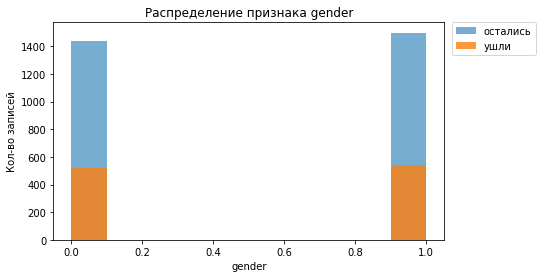

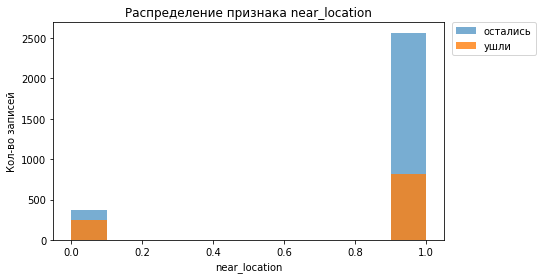

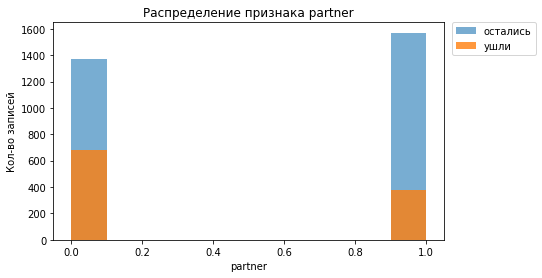

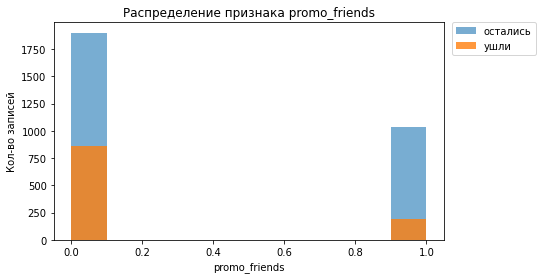

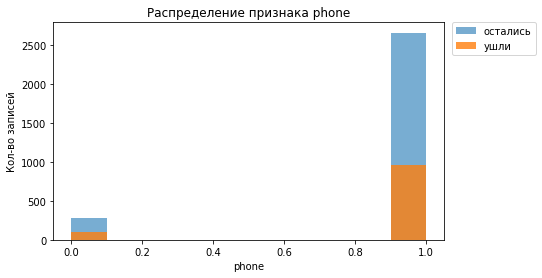

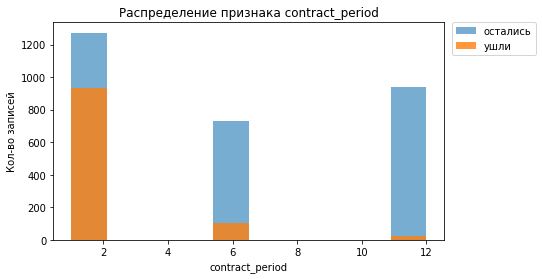

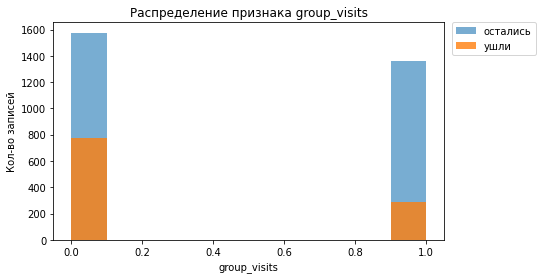

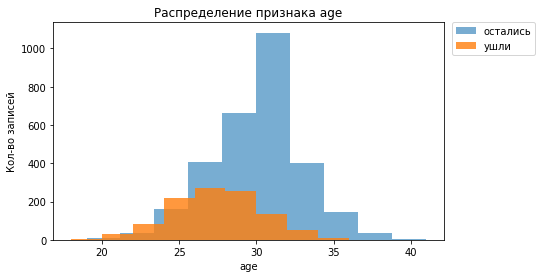

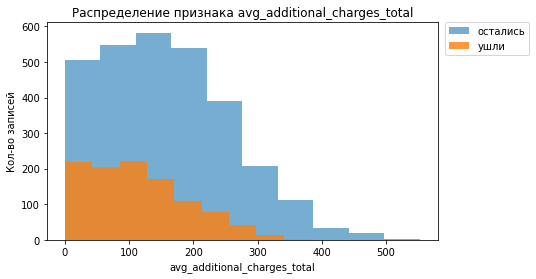

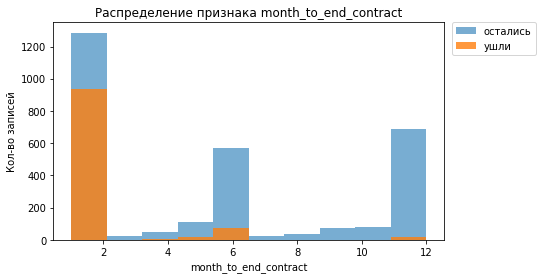

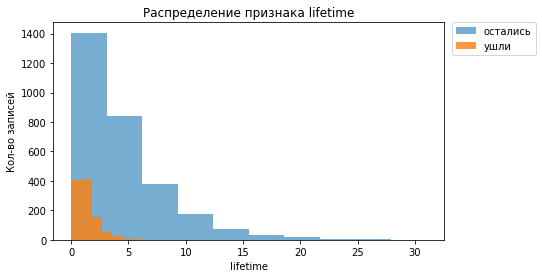

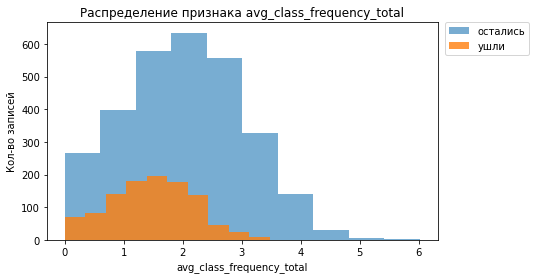

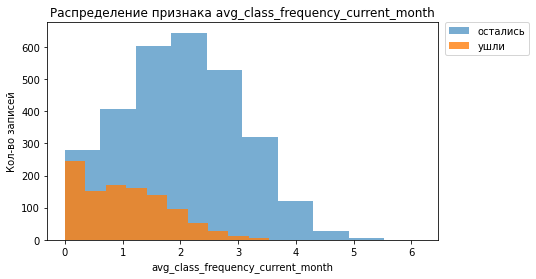

In [11]:
# построим столбчатые гистограммы и распределения признаков для обоих групп
for column in df.drop('churn', axis = 1):
    fig = plt.figure(figsize = (7,4))
    plt.hist(loyal_clients[column], alpha = 0.6, label='остались')
    plt.hist(churn_clients[column], alpha = 0.8, label='ушли')
    plt.title('Распределение признака ' + column)
    plt.ylabel('Кол-во записей')
    plt.xlabel(column)
    plt.legend(bbox_to_anchor=( 1.02 , 1 ), loc='upper left', borderaxespad= 0 )
    plt.show()

Распределение клиентов на графиках подтверждают ранее сделанные выводы.  

**Распределение:**  
* **По полу:** доли оттока примерно одинаковые и среди мужчин, и среди женщин.  


* **По расположению:** тех, кто живет или работает ближе значительно больше; и среди них доля оставшихся тоже значительно больше.  


* **Среди партнёров клуба:** те, кто является сотрудником компании-партнёра клуба, склонны продолжать ходить в фитнес.  


* **По акции "Приведи друга":** среди тех, кто воспользовался промо-акцией "Приведи друга" отток значитьлно меньше. Среди тех, кто не воспользовался, отток примерно 50%.  


* **По наличию телефона:** восновном все оставляют контактный ноиер; распределение оттока одинаково и не зависит от наличия или отсутствия телефона.  


* **По длительности текущего действующего абонемента:** чем дольше длительнось абонемента, тем у этих клиентов отток меньше. Абонементов на 1 месяц больше всего, и основной отток среди данных клиентов.  


* **По факту посещения групповых занятий:** большая часть тех, кто ходит на групповые занятия, склонны остаться.  


* **По возрасту:** по среднему возрасту обе группы имеют нормальное распределение, но датасет лояльных клиентов смещён вправо, а датасет ушедших клиентов - влево. Те кто уходит, чуть моложе.  


* **По суммарной выручке от других услуг фитнес-центра:** распределение средней выручки от других услуг в двух группах смещено влево с большим смещением для ушедших людей. То есть те, кто уходит, почти не тратят на дополнительные услуги в фитнес-центре.  


* **По сроку до окончания текущего действующего абонемента:** чем больше времени осталось до окончания абонемента, тем желание клиентов продолжать ходить в фитнес сильнее. Основной отток идет среди тех, у кого осталься 1 месяц.  


* **По времени с момента первого обращения в фитнес-центр:** среди тех, кто длительно посещает центр, оттока почти нет. Основной отток идет среди тех, кто ходил до 2 месяцев.  


* **По средней частоте посещений в неделю за все время с начала действия абонемента:** у тех, кто ходит до 2 раз в неделю, доли оттока примерно одинаковые; но ситуация резко меняется если клиент ходит 3 раза и более, отток снижается и сходит на нет, но таких клиентов значительно меньше.  


* **По средней частоте посещений в неделю за предыдущий месяц:** чем реже клиент ходил в клуб за последний месяц, тем и отток больше.

### Матрица корреляций

In [12]:
df_corr = df.corr()
df_corr

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
gender,1.00,0.01,-0.01,-0.01,-0.01,0.00,0.02,0.01,-0.01,-0.00,0.01,0.01,0.01,0.00
near_location,0.01,1.00,-0.01,0.21,-0.02,0.15,0.15,0.06,0.04,0.14,0.07,0.04,0.06,-0.13
partner,-0.01,-0.01,1.00,0.45,0.01,0.31,0.02,0.05,0.02,0.29,0.06,0.02,0.05,-0.16
promo_friends,-0.01,0.21,0.45,1.00,0.00,0.24,0.12,0.05,0.04,0.24,0.07,0.03,0.05,-0.16
phone,-0.01,-0.02,0.01,0.00,1.00,-0.01,-0.01,-0.01,0.01,-0.01,-0.02,0.01,0.01,-0.00
contract_period,0.00,0.15,0.31,0.24,-0.01,1.00,0.17,0.14,0.11,0.97,0.17,0.10,0.16,-0.39
group_visits,0.02,0.15,0.02,0.12,-0.01,0.17,1.00,0.08,0.03,0.16,0.08,0.06,0.08,-0.18
age,0.01,0.06,0.05,0.05,-0.01,0.14,0.08,1.00,0.08,0.13,0.16,0.12,0.18,-0.40
avg_additional_charges_total,-0.01,0.04,0.02,0.04,0.01,0.11,0.03,0.08,1.00,0.11,0.08,0.04,0.08,-0.20
month_to_end_contract,-0.00,0.14,0.29,0.24,-0.01,0.97,0.16,0.13,0.11,1.00,0.16,0.09,0.15,-0.38


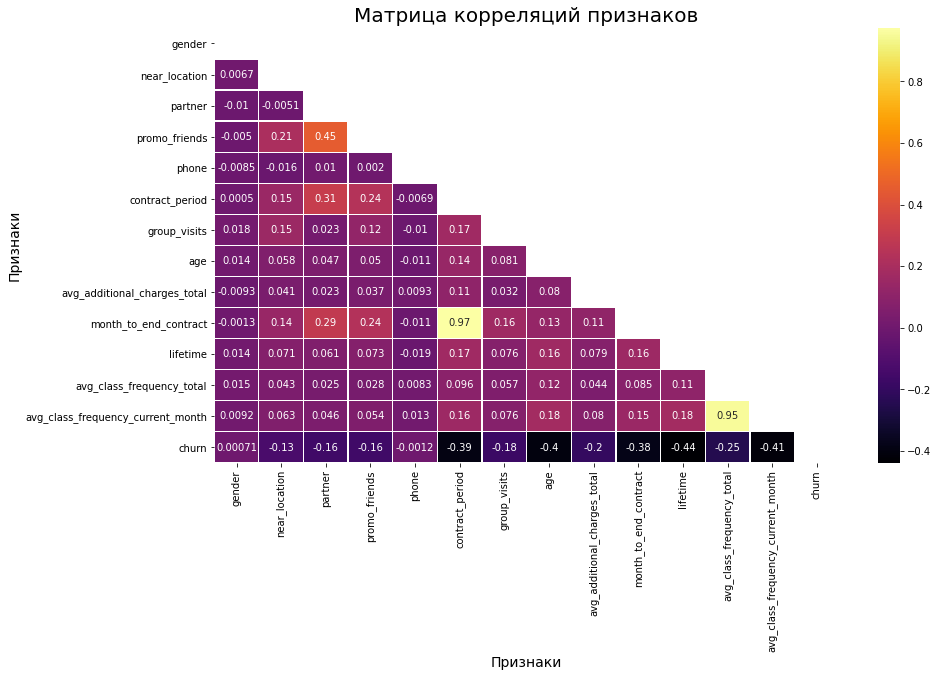

In [13]:
matrix = np.triu(df_corr)

plt.figure(figsize=(14,8))
sns.heatmap(df_corr, annot = True, mask=matrix, linewidths=.3, cmap= 'inferno')
plt.title('Матрица корреляций признаков', fontsize = 20)
plt.xlabel('Признаки', fontsize = 14)
plt.ylabel('Признаки', fontsize = 14) 
plt.show()

По матрице корреляции видим, что такие признаки как пол и наличие контактного телефона не влияют на конечный показатель оттока. Все остальные показатели имеют обратное влияние: слабое, либо чуть более сильное. Явно влияющих признаков, сильно связанных с результирующим показателем, предварительный анализ не выявил.

Имеется сильная связь между показателями длительности абонемента и количеством месяцев до конца абонемента. 

Также наблюдается сильная связь между средней частотой посещений в неделю с начала пользования услугами и за предыдущий месяц.  
Сильно коррелирующие признаки могут привести к проблеме мультиколлиниарности, это означает что мы можем избавиться от данных признаков.

In [14]:
#Чтобы эти признаки не искажали обучение, удалим их из модели  
df = df.drop(['month_to_end_contract', 'avg_class_frequency_total'], axis=1)

**Вывод**  
Анализ показателей:

**Отток клиентов.** У нас есть данные о клиентах, которые продолжают пользоваться услугами фитнес-центра (лояльные клиенты) и тех, кто "ушёл" (нелояльные клиенты). При этом в выборке больше тех, кто продолжает пользоваться услугами (средняя близка к 0,3, а медиана равна 0).  
Отток клиентов примерно 27%.

**Пол клиентов.** У нас имеются данные о мужчинах и женщинах. При этом в выборке их равное количество. Доли оттока примерно одинаковые и среди мужчин, и среди женщин.  
Это говорит о том, что этот признак не влияет на отток.

**Близость к фитнес-центру.** У нас имеются данные о людях, которые живут или работают рядом с фитнес-центром, либо в отдалённости от него. При этом в выборке больше тех, кто живёт или работает рядом (так как средняя близка к 0,85, а первый квартиль равен 1). А в группе, которая лояльна к фитнес-центру, чуть больше человек, которые живут или работают поблизости, чем тех, кто находится в отдалённости.  
Отток клиентов происходит чуть больше среди тех, кто находиться дальше от фитнес-центра. Можно сказать, что этот признак слабо влияет на отток.

**Сотрудники компании-партнёра.** Данные о людях, которые являются или не являются сотрудниками компании-партнёра клуба, представлены в выборке примерно в равной пропорции (средняя близка к 0,5).  
Есть различия в оттоке между сотрудниками компании-партнёра клуба. Среди партнеров оттток меньше.

**Промо-акция.** У нас имеются данные о людях, которые приобрели или не приобрели первый абонемент по акции "Приведи друга". При этом в обеих группах больше людей, которые приобрели первый абонемент не по промо-акции "Приведи друга" (так как средняя близка к 0,3, а медиана равна 0).  
Среди тех, кто воспользовался промо-акцией "Приведи друга" отток значитьлно меньше. Среди тех, кто не воспользовался, отток примерно 50%.

**Контактный телефон.** В имеющихся данных по клиентам либо есть данные о контактном телефоне, либо их нет. При этом в выборке больше тех, для кого представлена контактная информация (так как средняя близка к 0,9, а четвёртый квартиль равен 1) для обоих категорий: лояльных и нелояльных клиентов (распределения схожи).

**Возраст клиентов.** У нас имеются данные о клиентах возрастом от 18 до 41 года. Средний возраст равен 29 годам. Распределение для лояльных клиентов немного смещено вправо, а для ушедших клиентов - влево. Так, в группе лояльных фитнес-центру людей средний возраст составляет около 30 лет, а среди уходящих - около 27 лет. То есть вторая группа чуть младше.

**Время с первого обращения.** У нас имеются данные о клиентах, которые обращались в фитнес-центр впервые от 0 до 31 месяца назад. Среднее время с момента первого обращения составляет 3 месяца. Время с момента первого обращения для уходящих в отток равно 1 месяцу, а для тех, кто остался, близко к 5 месяцам. Скорее всего те, кто проявил активность в первые месяцы, не уйдут в отток.

**Длительность абонемента.** Действующий абонемент по рассматриваемым клиентам имеет срок в 1, 6 и 12 месяцев. Средняя длительность действующего абонемента составляет 4-5 месяцев. При этом есть перекос в данных: для большинства срок действующего абонемента равен 1 месяцу. Длительность действующего абонемента по оставшимся пользователям в среднем около 5-6 месяцев, а по ушедшим - 1-2 месяца. Это говорит о том, что купившие длительный абонемент с большей неохотой уйдут в отток, чем те, у кого он действует на короткий срок. Влияние признака на клиентов высокое.

**Время до окончания абонемента.** У нас имеются данные по клиентам, до окончания абонементов которых осталось от 1 до 12 месяцев. В среднем это значение около 4 месяцев. При этом больше половины всей выборки - это люди, до конца абонементов которых остался 1 месяц. Различия в распределении групп (лояльных и нелояльных клиентов) по сроку до окончания действующего абонемента такие же, как и в распределениях по длительности абонемента. В среднем срок до окончания действующего абонемента у людей, ушедших в отток, около 1-2 месяцев, а у оставшихся клиентов - около 5 месяцев. Это снова указывает на то, что уходят в большей степени те, у кого длительность оставшегося абонемента невысока.

**Групповые занятия.** У нас есть данные о клиентах, которые посещают групповые занятия или не посещают. При этом в выборке чуть больше тех, кто не посещает такие занятия (средняя близка к 0,4, а медиана равна 0). При этом среди лояльных клиентов распределение посещающих такие занятия и непосещающих примерно равномерно (вторых чуть больше); но среди тех, кто ушёл в отток, непосещающих групповые занятия значительно больше, чем тех, кто их посещает.

**Частота посещений за весь срок.** У нас имеются данные по клиентам со средней частотой посещений за все время с начала действия абонемента от 0 до 6 раз в неделю. В среднем это значение составляет около 2 раз в неделю. При этом выборка равномерная, так как среднее почти равно медиане, а стандартное отклонение невысоко. Лояльные клиенты, в среднем, посещают центр 2 раза в неделю, а ушедшие - от 1 до 2.  
У тех, кто занимается до 2 раз в неделю, доли оттока примерно одинаковые; но ситуация резко меняется если клиент ходит 3 раза и более, отток снижается и сходит на нет, но таких клиентов значительно меньше.

**Частота посещений за последний месяц.** У нас имеются данные по клиентам со средней частотой посещений за месяц от 0 до 6 раз в неделю. В среднем это значение составляет около 2 раз в неделю.  
Чем реже клиент ходил в клуб за последний месяц, тем отток больше.

**Выручка от прочих услуг.** Выручка от прочих услуг фитнес-центра с клиента составила от 0,15 до 552,6 у.е. В среднем это значение составляет около 147 у.е.(мы не знаем наверняка, в каких ден.ед. измеряются данные). Распределение средней выручки от других услуг фитнес-центра для обоих датасетов смещено влево с большим смещением для ушедших людей. То есть те, кто уходит, стараются минимизировать затраты на дополнительные услуги в фитнес-центре.



**Корреляция**  
Такие признаки как пол и наличие контактного телефона не влияют на конечный показатель оттока. Все остальные показатели имеют обратное влияние: слабое, либо чуть более сильное. Явно влияющих признаков, сильно связанных с результирующим показателем, предварительный анализ не выявил.

Имеется сильная связь между показателями длительности абонемента и количеством месяцев до конца абонемента.

Также наблюдается сильная связь между средней частотой посещений в неделю с начала пользования услугами и за предыдущий месяц.  

Мы удалили коррелирующие признаки, которые могут привести к проблеме мультиколлиниарности (срок до окончания текущего действующего абонемента, средняя частота посещений в неделю за все время с начала действия абонемента.

## Модель прогнозирования оттока клиентов

### Выделение обучающей и валидационной выборок

In [15]:
# Разделим данные на признаки (матрица x) и целевую переменную (y)
x = df.drop('churn', axis = 1)
y = df['churn']

# Разделим выборку на обучающую и валидационную в соотношении 80:20
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# Cтандартизируем данные
scaler = StandardScaler()
scaler.fit(x_train)
x_train_st = scaler.transform(x_train)
x_test_st = scaler.transform(x_test)

### Обучение модели

**Логистическая регрессия**

In [16]:
# Зададим алгоритм для модели
lr_model = LogisticRegression(random_state=0)

# Обучим модель
lr_model.fit(x_train_st, y_train)

# Воспользуемся обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(x_test_st)
lr_probabilities = lr_model.predict_proba(x_test_st)[:,1]

**Случайный лес**

In [17]:
# Зададим алгоритм для модели
rf_model = RandomForestClassifier(random_state=0)

# Обучим модель
rf_model.fit(x_train_st, y_train)

# Воспользуемся обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(x_test_st)
rf_probabilities = rf_model.predict_proba(x_test_st)[:,1]

### Оценка метрик и сравнение моделей

Создадим функцию для расчёта метрик: accuracy (доля правильных ответов), precision (точность), recall (полнота)

In [18]:
def metrics(y_true, y_pred, y_proba, name):
    print('Модель прогнозирования:', name) 
    print('Доля правильных ответов: accuracy = {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('Точность: precision = {:.2f}'.format(precision_score (y_true, y_pred)))
    print('Полнота: recall = {:.2f}'.format(recall_score(y_true, y_pred)))

In [19]:
# Рассчитаем метрики для модели логистической регрессии
metrics(y_test, lr_predictions, lr_probabilities, '"Логистическая регрессия"')
print()
# Рассчитаем метрики для модели случайного леса
metrics(y_test, rf_predictions, rf_probabilities, '"Случайный лес"')

Модель прогнозирования: "Логистическая регрессия"
Доля правильных ответов: accuracy = 0.90
Точность: precision = 0.79
Полнота: recall = 0.82

Модель прогнозирования: "Случайный лес"
Доля правильных ответов: accuracy = 0.90
Точность: precision = 0.81
Полнота: recall = 0.75


При построении модели мы разделили выборку на обучащую и валидационную в соотношении 80 к 20, то есть на 80% данных модель была обучена, а на 20% - проверена. После этого были построены и обучены 2 модели:  
алгоритмом "логистической регрессии" и алгоритмом "случайного леса".

Основные метрики полученных моделей следующие.  
Для модели "логистической регрессии": Accuracy = 0,90; Precision = 0,79; Recall = 0,82.  
Для модели "случайного леса": Accuracy = 0,90; Precision = 0,81; Recall = 0,75.  

Таким образом, обе модели достаточно хорошо способны делать прогноз. Однако, модель "логистической регрессии" подходит больше.

## Кластеризация клиентов

### Стандартизация данных

In [20]:
# Зададим "стандартизатор"
scaler = StandardScaler()

# Стандартизируем данные
x_sc = scaler.fit_transform(x)

### Построение матрицы расстояний и дендрограммы

In [21]:
# построим матрицу расстояний
links = linkage(x_sc, method = 'ward')

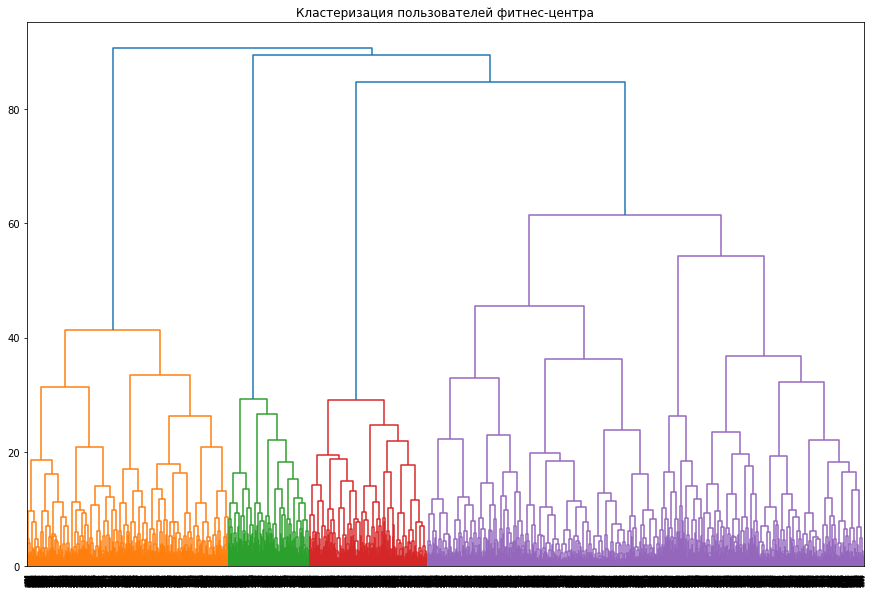

In [22]:
# Построим дендрограмму
plt.figure(figsize=(15, 10))
plt.title('Кластеризация пользователей фитнес-центра')
dendrogram(links, orientation='top')
plt.show()

По Дендрограмме видно, что можно выделить 4, 5 или 6 больших кластеров клиентов.

### Кластеризации по алгоритму K-Means и прогнозирование кластеров клиентов

Было принято решение для прогноза кластеров клиентов использовать пять кластеров.

In [23]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=0)
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 2)
labels = km.fit_predict(x_sc)

# сохраняем метки кластера в поле нашего датасета
df['cluster_km'] = labels

# Переименуем названия кластеров
df.loc[df['cluster_km']==0, 'cluster_km'] = 'cluster_1'
df.loc[df['cluster_km']==1, 'cluster_km'] = 'cluster_2'
df.loc[df['cluster_km']==2, 'cluster_km'] = 'cluster_3'
df.loc[df['cluster_km']==3, 'cluster_km'] = 'cluster_4'
df.loc[df['cluster_km']==4, 'cluster_km'] = 'cluster_5'

### Средние значения признаков для кластеров

In [25]:
# Выведем средние значения признаков для кластеров
df.groupby('cluster_km').mean().T

cluster_km,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5
gender,0.50,0.50,0.50,0.53,0.52
near_location,1.00,0.00,1.00,1.00,0.86
partner,0.89,0.49,0.22,0.38,0.47
promo_friends,1.00,0.08,0.07,0.01,0.31
phone,1.00,1.00,1.00,1.00,0.00
contract_period,6.92,2.99,2.01,6.21,4.78
group_visits,0.52,0.23,0.28,0.54,0.43
age,29.61,28.68,27.58,30.70,29.30
avg_additional_charges_total,153.42,137.13,119.34,176.26,144.21
lifetime,4.28,2.97,1.92,5.42,3.94


Мы видим, что в разных кластерах некоторые признаки практически не отличаются, а другие наоборт имеют сильный разброс.  
Чтобы более точно увидеть разницу в кластерах, построим распределение для каждого признака по кластерам.

### Анализ распределения признаков для кластеров

**Количество человек в каждом кластере**

In [26]:
df.groupby('cluster_km')['gender'].count()

cluster_km
cluster_1     985
cluster_2     558
cluster_3    1064
cluster_4    1007
cluster_5     386
Name: gender, dtype: int64

Можем выделить 3 наиболее многочисленные кластеры: 1, 3, 4  
Во 2 и 5 кластерах клиентов значительно меньше.

Для анализа распределения признаков в кластерах построим столбчатые диаграммы для логических и дискретных переменных (пол, близость к фитнес-центру, принадлежность к компании-партнёру, первое посещение по акции "Приведи друга", наличие контакта, длительность абонемента, посещение групповых занятий, отток) и боксплоты для непрерывных переменных (возраст, время с момента первого обращения, показатели средней частоты посещений в неделю за месяц, выручка от других услуг).

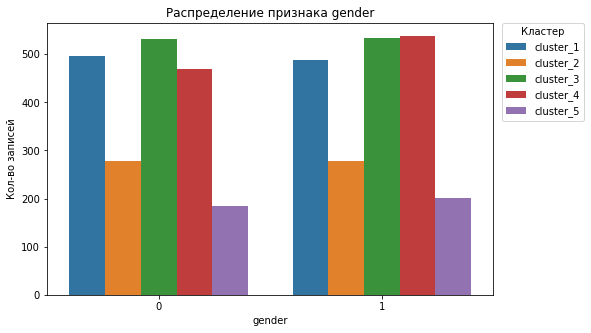

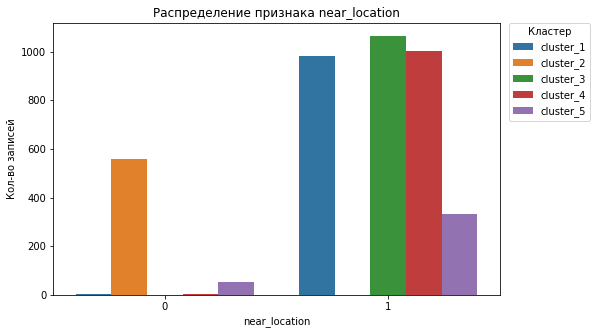

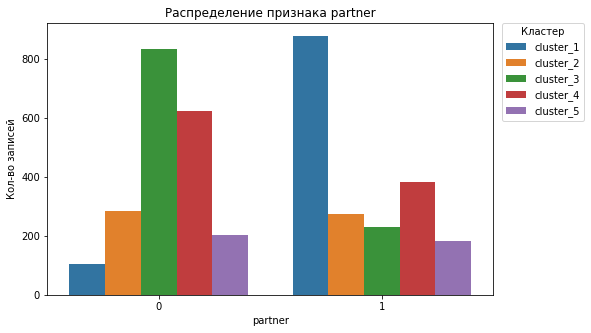

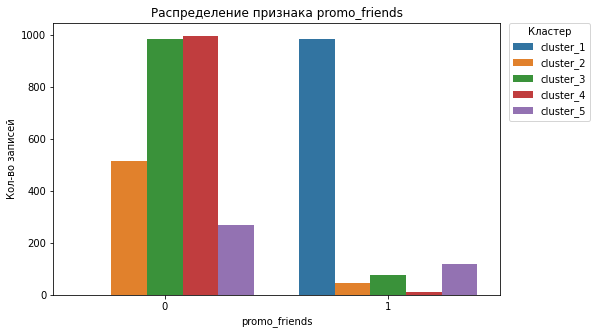

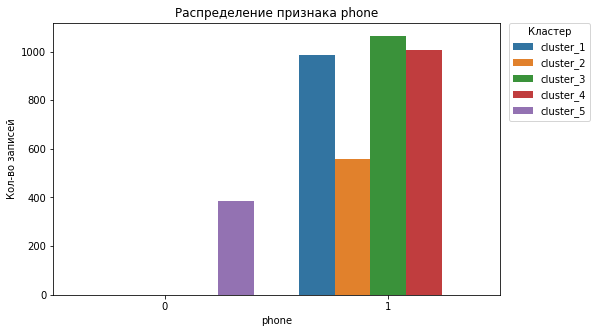

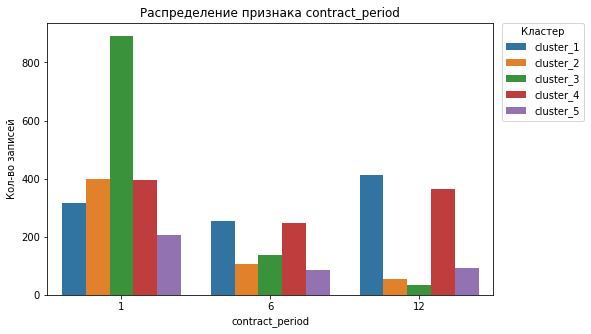

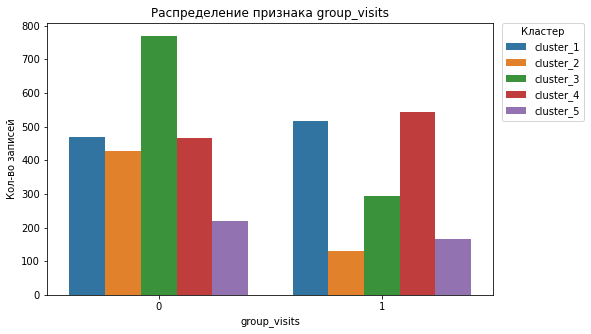

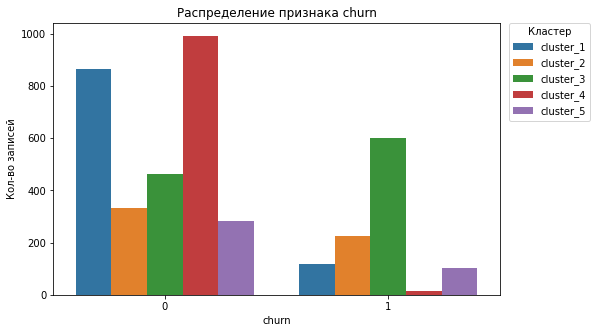

In [27]:
values = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'contract_period', 'group_visits', 'churn']
df_cl = df.sort_values(by='cluster_km')
for column in values:
    fig = plt.figure(figsize = (8,5))
    sns.countplot(data=df_cl, x=column, hue='cluster_km')
    plt.title('Распределение признака ' + column)
    plt.ylabel('Кол-во записей')
    plt.xlabel(column)
    plt.legend(title='Кластер', bbox_to_anchor=( 1.02 , 1 ), loc='upper left', borderaxespad= 0)
    plt.show()

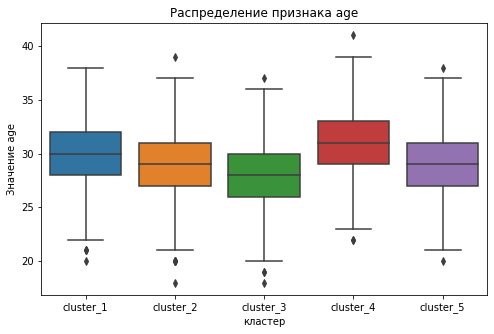

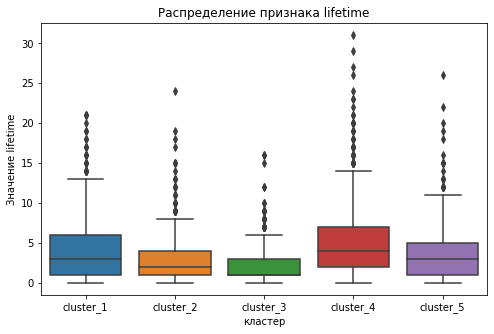

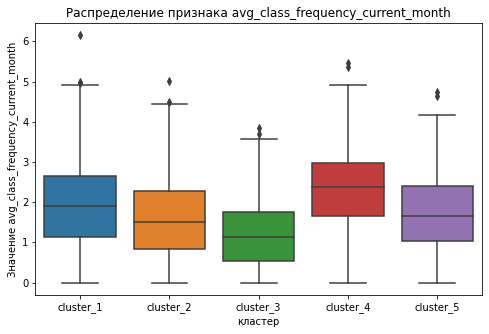

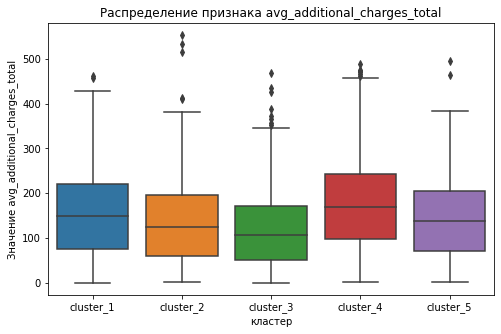

In [28]:
values = ['age', 'lifetime', 'avg_class_frequency_current_month', 'avg_additional_charges_total']

for column in values:
    fig = plt.figure(figsize = (8,5))
    plt.title("Распределение признака "+column)
    sns.boxplot(x='cluster_km', y=column, data=df_cl)
    plt.xlabel('кластер')
    plt.ylabel('Значение '+column)
    plt.show()

Кластер 1:  
* Количество человек - 985  
* Распределение по гендеру равномерное  
* Основное количество клиентов проживает или работает рядом с фитнес-центром  
* Большая часть из них являются сотрудниками фирм-партнеров  
* Все пришли по акции "Приведи друга"  
* Все оставили контактный телефон  
* Длительность абонемента распределена примерно равномерно (1,6 и 12 мес). Абонементов на 12 месяцев чуть больше.  
* Посещение групповых занятий примерно на 50% 
* Средний возраст - 30 лет
* В среднем посещают 3 месяца
* Занимаются 2 раза в неделю
* Средний уровень дополнительных оплат
* Несущественный отток клиентов  

Кластер 2:  
* Количество человек - 558  
* Распределение по гендеру равномерное  
* Основное количество клиентов проживает или работает вдали от фитнес-центра  
* Примерно половина являются сотрудниками фирм-партнеров  
* Большая часть не воспользовалась акцией "Приведи друга"  
* Все оставили контактный телефон  
* Длительность абонемента распределена неравномерно (1,6 и 12 мес). Абонементов на 1 месяц больше всего, на 12 меньше всего  
* Посещение групповых занятий примерно на 30% 
* Средний возраст - 29 лет
* В среднем посещают 2-3 месяца
* Занимаются 1-2 раза в неделю
* Средний уровень дополнительных оплат
* Отток клиентов значительный, примерно 40%  

Кластер 3:  
* Количество человек - 1064  
* Распределение по гендеру равномерное  
* Все клиенты проживают или работают рядом с фитнес-центром  
* Большая часть из них не являются сотрудниками фирм-партнеров (~80%)  
* Большая часть не воспользовалась акцией "Приведи друга"  
* Все оставили контактный телефон  
* Длительность абонемента распределена неравномерно (1,6 и 12 мес). Основная часть абонементов на 1 месяц, на 12 меньше всего  
* Посещение групповых занятий примерно на 30% 
* Средний возраст - 27 лет, самые молодые клиенты
* В среднем посещают 1-2 месяца
* Занимаются 1 раз в неделю, реже всех посещают в неделю
* Низкий уровень дополнительных оплат
* Отток клиентов самый значительный, примерно 60%  

Кластер 4:  
* Количество человек - 1007  
* Распределение по гендеру примерно равномерное  
* Основное количество клиентов проживает или работает рядом с фитнес-центром  
* Большая часть из них не являются сотрудниками фирм-партнеров (~60%)  
* Почти все не воспользовалась акцией "Приведи друга"  
* Все оставили контактный телефон  
* Длительность абонемента распределена примерно равномерно (1,6 и 12 мес). Абонементов на 6 месяцев чуть меньше  
* Посещение групповых занятий примерно на 55% 
* Средний возраст - 32 года, самые взрослые клиенты
* В среднем посещают 4 месяца, дольше всех посещают клуб
* Занимаются 2-3 раза в неделю, чаще всех посещают в неделю
* Высокий уровень дополнительных оплат
* Самый низкий отток клиентов, практически все остались  

Кластер 5:  
* Количество человек - 386  
* Распределение по гендеру примерно равномерное  
* Основное количество клиентов проживает или работает рядом с фитнес-центром, но есть и удаленные клиенты  
* Примерно половина являются сотрудниками фирм-партнеров  
* Большая часть не воспользовалась акцией "Приведи друга"  
* Никто не оставил контактный телефон  
* Длительность абонемента распределена неравномерно (1,6 и 12 мес). Абонементов на 1 месяцев больше, на 6 и 12 примерно равное количество  
* Посещение групповых занятий примерно на 45% 
* Средний возраст - 27-28 лет
* В среднем посещают 2,5 месяца
* Занимаются от 1 до 2 раз в неделю
* Средний уровень дополнительных оплат
* Отток клиентов значительный, примерно 30%  

### Доля оттока по кластерам

In [29]:
# Для каждого полученного кластера посчитаем долю оттока
(
    df.groupby('cluster_km')['churn']
   .mean()
   .reset_index()
   .sort_values(by='churn', ascending=False)
   .reset_index(drop=True)
)

,cluster_km,churn
0,cluster_3,0.56
1,cluster_2,0.40
2,cluster_5,0.27
3,cluster_1,0.12
4,cluster_4,0.01


Третий кластер более склонен к оттоку: доля около 56%. Второй кластер характеризуется долей оттока в 40%, а пятый - 27%. Первый и четвёртый кластеры (доля оттока 12% и 1%, соответственно) являются самыми надёжными.

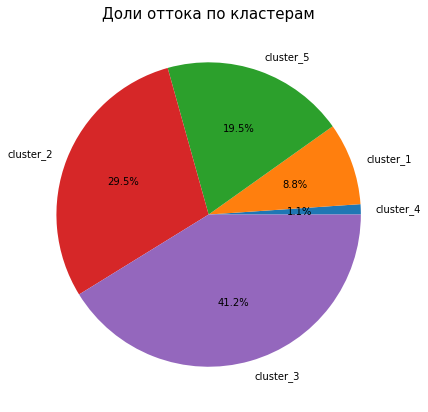

In [30]:
ax = (df.groupby('cluster_km')['churn'].mean().sort_values()
.plot(kind='pie', y='churn', autopct='%1.1f%%',  figsize=(7,7)))
plt.title('Доли оттока по кластерам', fontsize=15)
ax.set_ylabel('')
plt.show()

Доля от общего оттока по кластерам:  
Самая значительная - 3 кластер 41.2%  
2 кластер 29.5%  
5 кластер 19.5%  
1 кластер 8.8%  
4 кластер 1.1%

## Итог

Было проведено исследование данных о клиентах фитнес-центра «Культурист-датасаентист» с целью разработать стратегию взаимодействия с клиентами и и подготовить план действий по удержанию клиентов.  

Данные содержат в себе информацию о 4 000 клиентов и 14 показателях, один из которых (отток клиентов) выбран в модели в качестве результирующего.

В ходе предобработки:  
- привели названия столбцов к стандартному виду
- перевели значения месяцев в целочисленный тип данных

**Результаты EDA**  

**Отток клиентов.** У нас есть данные о клиентах, которые продолжают пользоваться услугами фитнес-центра (лояльные клиенты) и тех, кто "ушёл" (нелояльные клиенты). При этом в выборке больше тех, кто продолжает пользоваться услугами (средняя близка к 0,3, а медиана равна 0).  
Отток клиентов примерно 27%.

**Пол клиентов.** У нас имеются данные о мужчинах и женщинах. При этом в выборке их равное количество. Доли оттока примерно одинаковые и среди мужчин, и среди женщин.  
Это говорит о том, что этот признак не влияет на отток.

**Близость к фитнес-центру.** У нас имеются данные о людях, которые живут или работают рядом с фитнес-центром, либо в отдалённости от него. При этом в выборке больше тех, кто живёт или работает рядом (так как средняя близка к 0,85, а первый квартиль равен 1). А в группе, которая лояльна к фитнес-центру, чуть больше человек, которые живут или работают поблизости, чем тех, кто находится в отдалённости.  
Отток клиентов происходит чуть больше среди тех, кто находиться дальше от фитнес-центра. Можно сказать, что этот признак слабо влияет на отток.

**Сотрудники компании-партнёра.** Данные о людях, которые являются или не являются сотрудниками компании-партнёра клуба, представлены в выборке примерно в равной пропорции (средняя близка к 0,5).  
Есть различия в оттоке между сотрудниками компании-партнёра клуба. Среди партнеров оттток меньше.

**Промо-акция.** У нас имеются данные о людях, которые приобрели или не приобрели первый абонемент по акции "Приведи друга". При этом в обеих группах больше людей, которые приобрели первый абонемент не по промо-акции "Приведи друга" (так как средняя близка к 0,3, а медиана равна 0).  
Среди тех, кто воспользовался промо-акцией "Приведи друга" отток значитьлно меньше. Среди тех, кто не воспользовался, отток примерно 50%.

**Контактный телефон.** В имеющихся данных по клиентам либо есть данные о контактном телефоне, либо их нет. При этом в выборке больше тех, для кого представлена контактная информация (так как средняя близка к 0,9, а четвёртый квартиль равен 1) для обоих категорий: лояльных и нелояльных клиентов (распределения схожи).

**Возраст клиентов.** У нас имеются данные о клиентах возрастом от 18 до 41 года. Средний возраст равен 29 годам. Распределение для лояльных клиентов немного смещено вправо, а для ушедших клиентов - влево. Так, в группе лояльных фитнес-центру людей средний возраст составляет около 30 лет, а среди уходящих - около 27 лет. То есть вторая группа чуть младше.

**Время с первого обращения.** У нас имеются данные о клиентах, которые обращались в фитнес-центр впервые от 0 до 31 месяца назад. Среднее время с момента первого обращения составляет 3 месяца. Время с момента первого обращения для уходящих в отток равно 1 месяцу, а для тех, кто остался, близко к 5 месяцам. Скорее всего те, кто проявил активность в первые месяцы, не уйдут в отток.

**Длительность абонемента.** Действующий абонемент по рассматриваемым клиентам имеет срок в 1, 6 и 12 месяцев. Средняя длительность действующего абонемента составляет 4-5 месяцев. При этом есть перекос в данных: для большинства срок действующего абонемента равен 1 месяцу. Длительность действующего абонемента по оставшимся пользователям в среднем около 5-6 месяцев, а по ушедшим - 1-2 месяца. Это говорит о том, что купившие длительный абонемент с большей неохотой уйдут в отток, чем те, у кого он действует на короткий срок. Влияние признака на клиентов высокое.

**Время до окончания абонемента.** У нас имеются данные по клиентам, до окончания абонементов которых осталось от 1 до 12 месяцев. В среднем это значение около 4 месяцев. При этом больше половины всей выборки - это люди, до конца абонементов которых остался 1 месяц. Различия в распределении групп (лояльных и нелояльных клиентов) по сроку до окончания действующего абонемента такие же, как и в распределениях по длительности абонемента. В среднем срок до окончания действующего абонемента у людей, ушедших в отток, около 1-2 месяцев, а у оставшихся клиентов - около 5 месяцев. Это снова указывает на то, что уходят в большей степени те, у кого длительность оставшегося абонемента невысока.

**Групповые занятия.** У нас есть данные о клиентах, которые посещают групповые занятия или не посещают. При этом в выборке чуть больше тех, кто не посещает такие занятия (средняя близка к 0,4, а медиана равна 0). При этом среди лояльных клиентов распределение посещающих такие занятия и непосещающих примерно равномерно (вторых чуть больше); но среди тех, кто ушёл в отток, непосещающих групповые занятия значительно больше, чем тех, кто их посещает.

**Частота посещений за весь срок.** У нас имеются данные по клиентам со средней частотой посещений за все время с начала действия абонемента от 0 до 6 раз в неделю. В среднем это значение составляет около 2 раз в неделю. При этом выборка равномерная, так как среднее почти равно медиане, а стандартное отклонение невысоко. Лояльные клиенты, в среднем, посещают центр 2 раза в неделю, а ушедшие - от 1 до 2.  
У тех, кто занимается до 2 раз в неделю, доли оттока примерно одинаковые; но ситуация резко меняется если клиент ходит 3 раза и более, отток снижается и сходит на нет, но таких клиентов значительно меньше.

**Частота посещений за последний месяц.** У нас имеются данные по клиентам со средней частотой посещений за месяц от 0 до 6 раз в неделю. В среднем это значение составляет около 2 раз в неделю.  
Чем реже клиент ходил в клуб за последний месяц, тем отток больше.

**Выручка от прочих услуг.** Выручка от прочих услуг фитнес-центра с клиента составила от 0,15 до 552,6 у.е. В среднем это значение составляет около 147 у.е.(мы не знаем наверняка, в каких ден.ед. измеряются данные). Распределение средней выручки от других услуг фитнес-центра для обоих датасетов смещено влево с большим смещением для ушедших людей. То есть те, кто уходит, стараются минимизировать затраты на дополнительные услуги в фитнес-центре.



**Корреляция**  
Такие признаки как пол и наличие контактного телефона не влияют на конечный показатель оттока. Все остальные показатели имеют обратное влияние: слабое, либо чуть более сильное. Явно влияющих признаков, сильно связанных с результирующим показателем, предварительный анализ не выявил.

Имеется сильная связь между показателями длительности абонемента и количеством месяцев до конца абонемента.

Также наблюдается сильная связь между средней частотой посещений в неделю с начала пользования услугами и за предыдущий месяц.  

Мы удалили коррелирующие признаки, которые могут привести к проблеме мультиколлиниарности (срок до окончания текущего действующего абонемента, средняя частота посещений в неделю за все время с начала действия абонемента.

**Основные метрики полученных моделей**  

Для модели "логистической регрессии": Accuracy = 0,90; Precision = 0,79; Recall = 0,82.
Для модели "случайного леса": Accuracy = 0,90; Precision = 0,81; Recall = 0,75.

Таким образом, обе модели достаточно хорошо способны делать прогноз. Однако, модель "логистической регрессии" подходит больше.

**Кластеризация клиентов**  

По дендрограмме было высказано предположение о наличии четырёх кластеров в данных. Однако, было принято решение для прогноза  использовать пять кластеров в модели *K-Means*.

Анализ признаков для кластеров показал, что выделенные кластеры имеют следующие отличительные характеристики:  

**Кластер 1:**

Количество человек - 985  
Клиенты проживающие или работающие рядом с фитнес-центром  
Большая часть из них являются сотрудниками фирм-партнеров, а так же пришли по акции "Приведи друга"  
Имеющие абонементы на 1,6 и 12 мес. С преобладание абонементов на 12 месяцев.  
Для половины клиентов групповые занятия важны  
Средний возраст - 30 лет  
В среднем посещают клуб 3 месяца  
Занимаются 2 раза в неделю  
Средний уровень дополнительных оплат  
Доля оттока в кластере - 12%  
Доля оттока от общего числа клиентов - 8,8%  

**Кластер 2:**

Количество человек - 558   
Основное количество клиентов проживает или работает вдали от фитнес-центра  
Примерно половина являются сотрудниками фирм-партнеров  
Большая часть не воспользовалась акцией "Приведи друга"  
В основном приобрели абонементы на 1 месяц, на 12 меньше всего.  
Посещение групповых занятий важно примерно на 30%  
Средний возраст - 29 лет  
В среднем посещают клуб 2-3 месяца  
Занимаются 1-2 раза в неделю  
Средний уровень дополнительных оплат  
Доля оттока в кластере - 40%  
Доля оттока от общего числа клиентов - 29,5%  

**Кластер 3:**

Количество человек - 1064  
Все клиенты проживают или работают рядом с фитнес-центром  
Большая часть из них не являются сотрудниками фирм-партнеров (~80%), а так же не воспользовалась акцией "Приведи друга"  
Основная часть абонементов на 1 месяц, на 12 меньше всего  
Посещение групповых занятий важно примерно на 30%  
Средний возраст - 27 лет, самые молодые клиенты  
В среднем посещают клуб 1-2 месяца  
Занимаются 1 раз в неделю, реже всех посещают в неделю  
Низкий уровень дополнительных оплат  
Доля оттока в кластере - 56%  
Доля оттока от общего числа клиентов - 41,2%  
Это наиболее склонный к оттоку кластер  

**Кластер 4:**

Количество человек - 1007  
Основное количество клиентов проживает или работает рядом с фитнес-центром  
Большая часть из них не являются сотрудниками фирм-партнеров (~60%)  
Почти все не воспользовалась акцией "Приведи друга"  
Длительность абонемента распределена примерно равномерно (1,6 и 12 мес). Абонементов на 6 месяцев чуть меньше  
Посещение групповых занятий важно примерно на 55%  
Средний возраст - 32 года, самые взрослые клиенты  
В среднем посещают 4 месяца, дольше всех посещают клуб  
Занимаются 2-3 раза в неделю, чаще всех посещают в неделю  
Высокий уровень дополнительных оплат  
Доля оттока в кластере - 1%  
Доля оттока от общего числа клиентов - 1,1%  
Самый низкий отток клиентов  

**Кластер 5:**

Количество человек - 386  
Основное количество клиентов проживает или работает рядом с фитнес-центром, но есть и удаленные клиенты  
Примерно половина являются сотрудниками фирм-партнеров  
Большая часть не воспользовалась акцией "Приведи друга"  
Никто из клиентов кластера не оставил контактный телефон  
Длительность абонемента распределена неравномерно (1,6 и 12 мес). Абонементов на 1 месяцев больше, на 6 и 12 примерно равное количество  
Посещение групповых занятий важно примерно на 45%  
Средний возраст - 27-28 лет  
В среднем посещают 2,5 месяца  
Занимаются от 1 до 2 раз в неделю  
Средний уровень дополнительных оплат  
Доля оттока в кластере - 27%  
Доля оттока от общего числа клиентов - 19,5%   

**Рекомендации**  

1. Будет полезно проанализировать влияние дополнительного признака - индивидуальные занятия с тренером. 
2. Рекомендуется привлечение в фитнес-центр клиентов из близлежащих районов. 
3. Рекомендуется отменить или пересмотреть условия абонементов по акции "Приведи друга".  Так как данной акцией почти никто не пользуется. А влияние на отток не однозначное.  
4. Продвигать абонементы более длительного срока (9 и 12 месяцев), возможно сделать более выгодные цены на длительные абонементы.
5. Рекомендуется внедрить пробные посещения вместо абонементов на 1 месяц. Так человек сможет познакомиться с услугами фитнес-центра. А вместо абонемента на 1 месяц предлагать на 3 месяца ненамного дороже,  это снизит риски оттока клиентов в первые месяцы за счет выработки привычки.
6. Возможно ввести более выгодное продление абонемента для клиентов
7. Продвигать участие в групповых занятиях, так как новые связи и план занятий способствуют вовлечению. 
8. Рекомендуется проводить мониторинг средней частоты посещений фитнес-центра в неделю по клиентам. При обнаружении снижения показателя предлагать клиентам бонусы - бесплатная разовая доп. услуга, скидки на продление абонемента, одно бесплатное групповое занятие по новому для него направлению и т.п.